In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import glob
import statistics
import math
from tqdm import tqdm
from os import listdir
import os
from os.path import isfile, join
from coolpuppy import coolpup, plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from matplotlib.patches import Rectangle
from collections import Counter
from pybedtools import BedTool as pbt
from scipy.stats import fisher_exact

### 1. Inspect TADs groups

In [9]:
def prepare_borders(boundaries_unique):
    boundaries_unique = boundaries_unique.iloc[:, [0,1,2]]
    boundaries_unique.columns = ['chrom', 'start', 'end']
    boundaries_unique['border_center'] = (boundaries_unique.end + boundaries_unique.start)//2
    boundaries_unique.border_center = [int(i) for i in boundaries_unique.border_center]
    return boundaries_unique

def make_boundaries(tad_hc_plus_df):
    tad_hc_plus_df["chrom1"] = tad_hc_plus_df["chrom"] 
    tad_hc_plus_df["start1"] = tad_hc_plus_df["start"]
    tad_hc_plus_df["end1"] = tad_hc_plus_df["start"] + 15_000
    tad_hc_plus_df["chrom2"] = tad_hc_plus_df["chrom"] 
    tad_hc_plus_df["start2"] = tad_hc_plus_df["end"] - 15_000
    tad_hc_plus_df["end2"] = tad_hc_plus_df["end"]
    tad_hc_plus_df = tad_hc_plus_df[["chrom1","start1", "end1","chrom2","start2","end2","group"]]
    return tad_hc_plus_df

def identify_group(boundaries_hc_minus, tad_united):
    tad_hc_minus = []
    for i in range(boundaries_hc_minus.shape[0]-1):
        tad_hc_minus.append(boundaries_hc_minus.end[i+1] - boundaries_hc_minus.start[i])
    tad_hc_minus = [i for i in tad_hc_minus if i > 0]
    groups = np.quantile(tad_united, [0,0.33, 0.67,1])
    tad_hc_minus_groups = []
    for item in tad_hc_minus:
        if item <=groups[1]:
            tad_hc_minus_groups.append(0)
        if item <=groups[2] and item > groups[1]:
            tad_hc_minus_groups.append(1)
        if item > groups[2]:
            tad_hc_minus_groups.append(2)
    tad_hc_minus_ch,tad_hc_minus_start ,tad_hc_minus_end  = [],[],[]
    for i in range(boundaries_hc_minus.shape[0]-1):
        if boundaries_hc_minus.chrom[i+1] == boundaries_hc_minus.chrom[i]:
            tad_hc_minus_ch.append(boundaries_hc_minus.chrom[i])
            tad_hc_minus_start.append(boundaries_hc_minus.start[i])
            tad_hc_minus_end.append(boundaries_hc_minus.end[i+1])
    tad_hc_minus_df = pd.DataFrame(zip(tad_hc_minus_ch,tad_hc_minus_start,tad_hc_minus_end),columns = ['chrom', 'start', 'end'])
    tad_hc_minus_df["group"] = tad_hc_minus_groups
    tad_hc_minus_df = make_boundaries(tad_hc_minus_df)
    return tad_hc_minus_df

def identify_group_simple(s):    
    groups = np.quantile(s, [0,0.33,0.67,1])
    tad_hc_minus_groups = []
    for item in s:
        if item <=groups[1]:
            tad_hc_minus_groups.append(0)
        if item <=groups[2] and item > groups[1]:
            tad_hc_minus_groups.append(1)
        if item > groups[2]:
            tad_hc_minus_groups.append(2)
    return tad_hc_minus_groups  

In [3]:
boundaries_minus = pd.read_csv("../data/boundaries_minus_annotaed.csv")
boundaries_plus= pd.read_csv("../data/boundaries_plus_annotaed.csv")

boundaries_plus_common = boundaries_plus[boundaries_plus.status.isin(["common"])].reset_index(drop=True)
boundaries_minus_common = boundaries_minus[boundaries_minus.status.isin(["common"])].reset_index(drop=True)

In [7]:
united = pd.concat([boundaries_minus_common[['chrom', 'start', 'end']], boundaries_plus_common[['chrom', 'start', 'end']]]).reset_index(drop=True)

tad_hc_minus = []
for i in range(united.shape[0]-1):
    tad_hc_minus.append(united.end[i+1] - united.start[i])
tad_hc_minus = [i for i in tad_hc_minus if i > 0]
groups = np.quantile(tad_hc_minus, [0,0.33, 0.67,1])

In [10]:
tads_plus_common_tad_size = identify_group(boundaries_plus_common, tad_hc_minus)
tads_minus_common_tad_size = identify_group(boundaries_minus_common, tad_hc_minus)

tad_minus_all_tad_size = identify_group_simple(boundaries_minus)
tad_plus_all_tad_size = identify_group_simple(boundaries_plus)

### 2. Plot average TAD (by group)

In [10]:
def prepare_border_file(file):    
    file1 = file[["chrom1", "start1","end2","group"]]
    file1.columns = ["chrom", "start","end","group"]    
    return file1
def prepare_border_file_exp(file):    
    file1 = file[["chrom1", "start1","end2","group_exp"]]
    file1.columns = ["chrom", "start","end","group"]    
    return file1

def build_average_tad_self_border(file_plus, file_minus, clrs_25_map, exps_25_map, resolution):
    file_usage_plus = prepare_border_file(file_plus)
    file_usage_minus = prepare_border_file(file_minus)
    names = ["clr_HC_plus","clr_HC_minus"]
    groups = [0,1,2]
    stacks =[]
    for group in groups:
        file_usage_group_plus = file_usage_plus[file_usage_plus["group"]==group]  
        file_usage_group_minus = file_usage_minus[file_usage_minus["group"]==group]
        files_usage = [file_usage_group_plus, file_usage_group_minus]
        for i, file in enumerate(files_usage):   
            cc = coolpup.CoordCreator(file, resolution=resolution, features_format='bed', local=True, 
                                      rescale_flank=1)
            pu = coolpup.PileUpper(clrs_25_map[i], cc, expected=exps_25_map[i],
                                   view_df=hg38_arms, 
                                   ignore_diags=0, 
                                   rescale_size=99, rescale=True)
            pup = pu.pileupsWithControl(nproc=10)
            stacks.append((pup.data)[0])
    return stacks


In [11]:
def visualize_tad_average_all(file):
    modes = ['neurons/glia', 'neuronal Hi-C data', 'glial Hi-C data']
    cell_types = ['NeuN+', 'NeuN-']
    phenotypes = ['HC', 'SZ']
    vmin, vmax = -0.6, 0.6  
    for num, mode in enumerate(modes):
        fig, axs = plt.subplots(2, 3, figsize=(5, 5),
                                gridspec_kw={'width_ratios': [1, 1, 0.1]})
        cnt = num * len(cell_types) * len(phenotypes) * 2 
        for i, ct in enumerate(cell_types):
            for j, phen in enumerate(phenotypes):
                map_inv = calculate_map_inv(file, cnt, mode)
                im = plot_heatmap(axs[i, j], map_inv, vmin, vmax)
                cnt += 2  
        finalize_figure(axs, im)
        plt.tight_layout()

def calculate_map_inv(file, cnt, mode):
    if mode == 'neurons/glia':
        return file[cnt] / file[cnt + 1]
    else:
        return file[cnt]

def plot_heatmap(ax, data, vmin, vmax):
    im = ax.imshow(np.log2(data), vmin=vmin, vmax=vmax, cmap='coolwarm')
    ax.set_xticks([])
    ax.set_yticks([])
    return im

def finalize_figure(axs, im):
    plt.colorbar(im, cax=axs[0, 2])
    axs[0, 2].set_box_aspect(10)
    axs[0, 2].set_ylabel("log2(mean intensity)")
    axs[1, 2].axis('off') 

In [17]:
def visualize_tad_average_all_exp_4(average_tad_neuron_TADs_size, group):
    plt.rcParams['axes.facecolor'] = 'white'
    sns.set_style("ticks")
    groups = ["size", "expression", "gene_size"]
    plus_file = [average_tad_neuron_TADs_size[i] for i in range(8) if i % 2 == 0]
    minus_file = [average_tad_neuron_TADs_size[i] for i in range(8) if i % 2 != 0]
    
    element = groups.index(group)
    modes = ['neurons/glia', 'neuronal Hi-C data', 'glial Hi-C data']
    sets = [
        [plus_file[i] / minus_file[i] for i in range(4)],
        plus_file[:4],
        minus_file[:4]
    ]    
    for e, mode in enumerate(modes):
        fig, axs = plt.subplots(1, 5, figsize=(15, 10), dpi=250,
                                gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.1]})
        model_set = sets[e]
        vmin, vmax = (-0.4, 0.4) if e == 0 else (-0.9, 0.9)
        for i in range(4):
            im = axs[i].imshow(np.log2(model_set[i]), vmin=vmin, vmax=vmax, cmap='coolwarm')
            axs[i].set_xticks([])
            axs[i].set_yticks([])
        plt.colorbar(im, cax=axs[4])
        axs[4].set_box_aspect(10) 
        axs[4].set_ylabel("log2(mean intensity)")
        axs[0].set_ylabel(f"{mode}")
        
        plt.tight_layout()

In [18]:
### Prepare Hi-C files
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

res = 10_000
path_to_maps = "/tank/projects/schizophrenia_2021/hi-c/our_data/2022.11_2"

clr_HC_minus_new10 = cooler.Cooler(f'{path_to_maps}/NeuNminus.sampled.1000.mcool::/resolutions/{resolution}')
clr_HC_plus_new10 = cooler.Cooler(f'{path_to_maps}/NeuNplus.sampled.1000.mcool::/resolutions/{resolution}')

hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
expected_minus_new10_nod = expected_cis(
    clr_HC_minus_new10,
    ignore_diags=0,
    view_df=hg38_arms,
    chunksize=1000000,
    nproc=15)

expected_plus_new10_nod = expected_cis(
    clr_HC_plus_new10,
    ignore_diags=0,
    view_df=hg38_arms,
    chunksize=1000000,
    nproc=15
    )

clrs_10 = [clr_HC_plus_new10,clr_HC_minus_new10]
exps_10 = [expected_plus_new10_nod, expected_minus_new10_nod]

In [19]:
average_tad = build_average_tad_self_border(tad_plus_all_tad_size,tad_minus_all_tad_size, clrs_10, exps10)

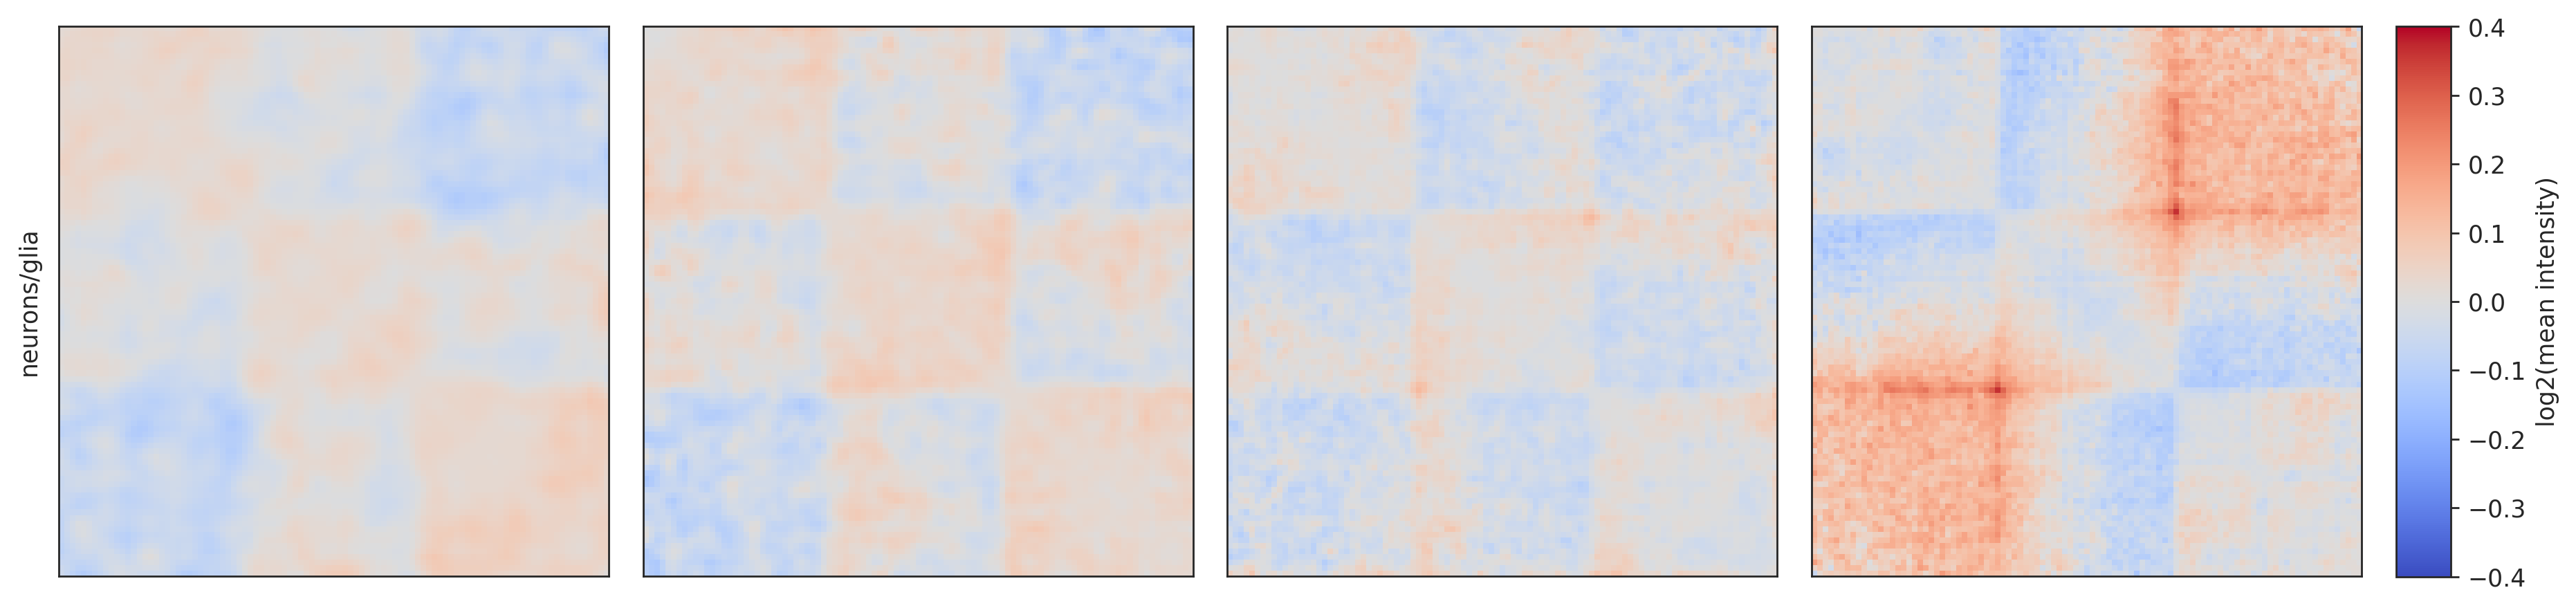

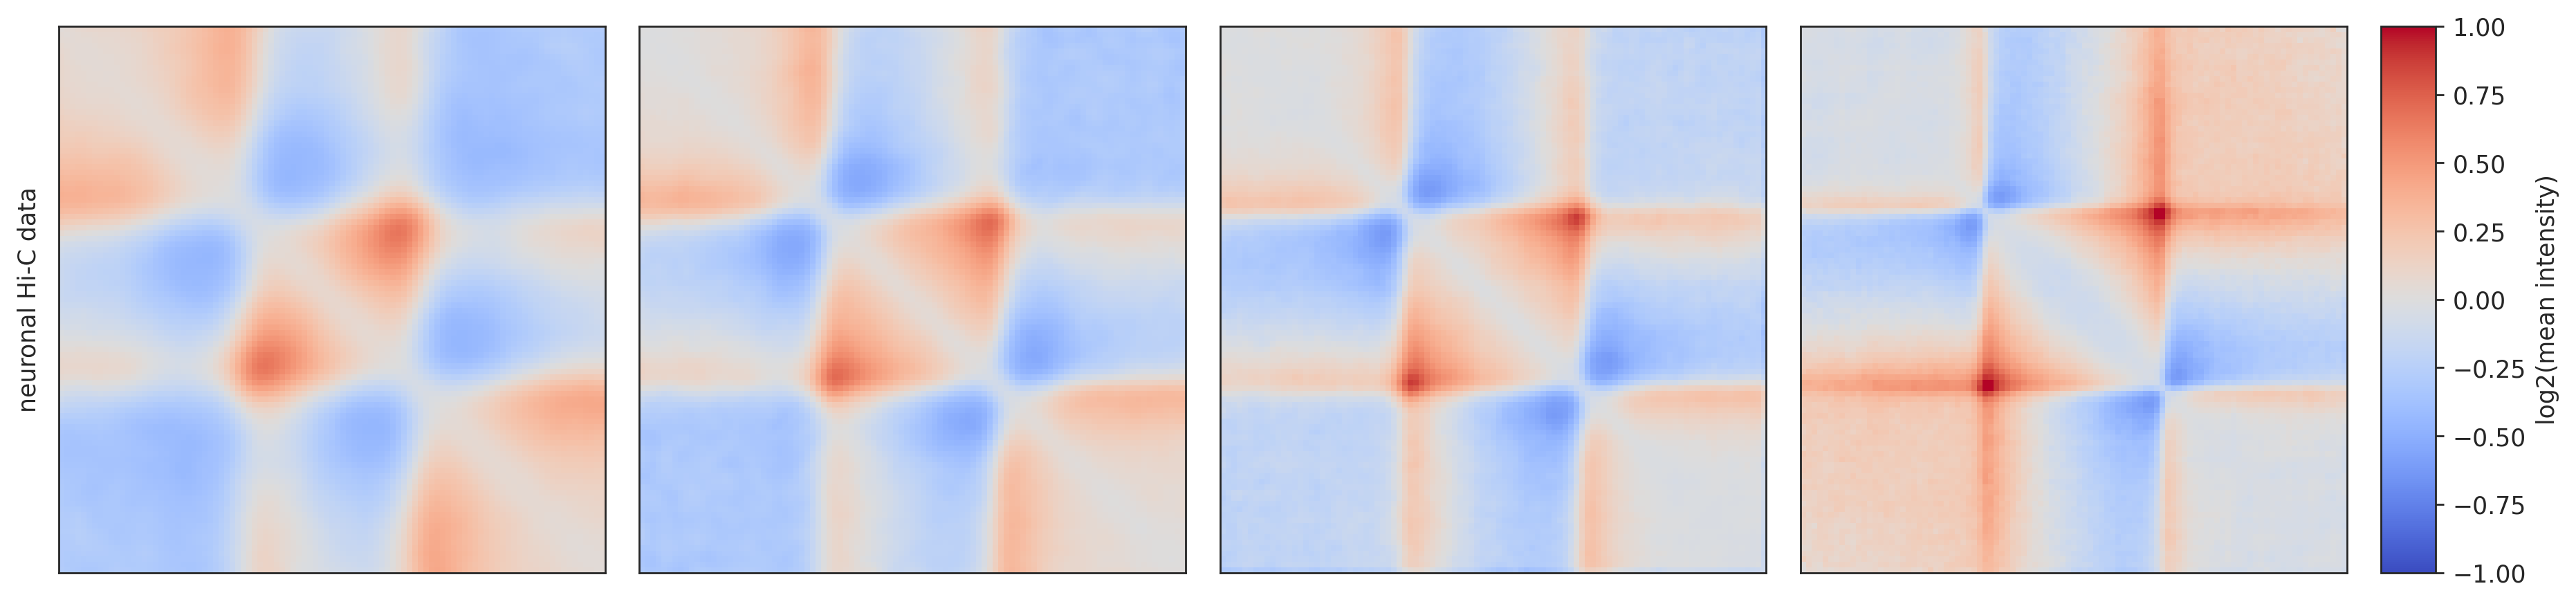

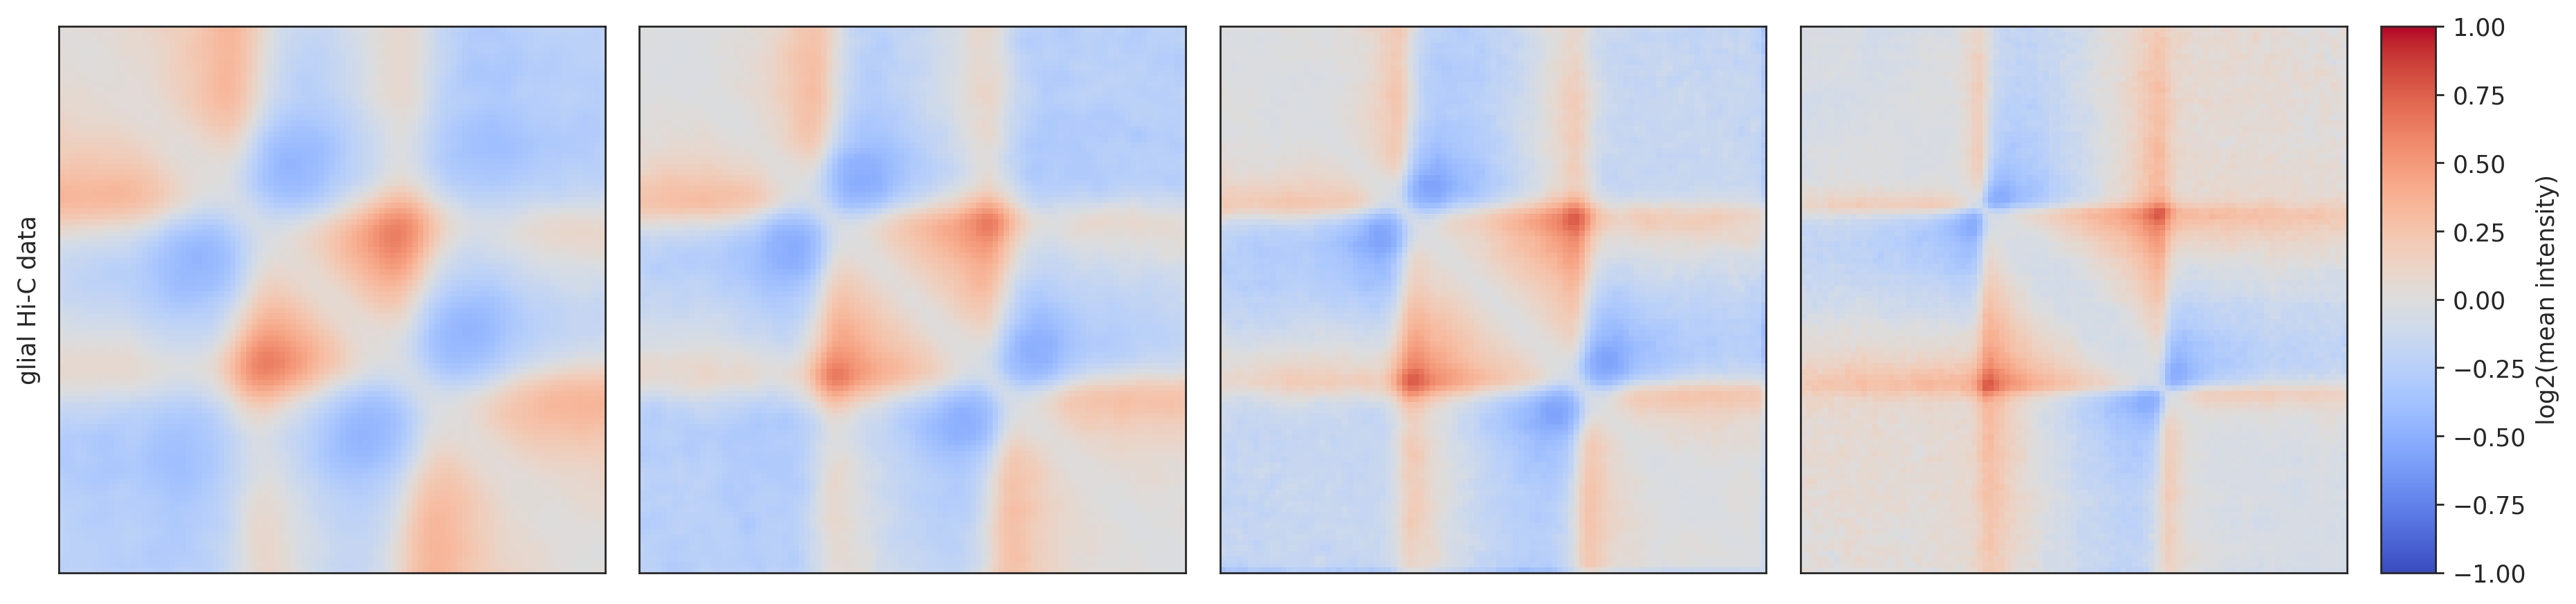

In [149]:
n_list_plus = [ i for i in tads_plus_common_tad_size.groupby("group").size()]
n_list_minus = [ i for i in tads_minus_common_tad_size.groupby("group").size()]
visualize_tad_average_all_exp_4(average_tad, "size")

### 3. Plot average TADs (by cell type)

In [22]:
def prepare_border_file(file):    
    file1 = file[["chrom1", "start1","end2","group"]]
    file1.columns = ["chrom", "start","end","group"]    
    return file1
def prepare_border_file_exp(file):    
    file1 = file[["chrom1", "start1","end2","group_exp"]]
    file1.columns = ["chrom", "start","end","group"]    
    return file1

def build_average_tad_self_border_no_groups(file_plus, file_minus, clrs_25_map, exps_25_map, resolution):
    file_usage_plus = prepare_border_file(file_plus)
    file_usage_minus = prepare_border_file(file_minus)
    names = ["clr_HC_plus","clr_HC_minus"]
    stacks =[]   
    file_usage_group_plus = file_usage_plus
    file_usage_group_minus = file_usage_minus
    files_usage = [file_usage_group_plus, file_usage_group_minus]
    for i, file in enumerate(files_usage):   
        cc = coolpup.CoordCreator(file, resolution=resolution, features_format='bed', local=True, 
                                  rescale_flank=1)
        pu = coolpup.PileUpper(clrs_25_map[i], cc, expected=exps_25_map[i],
                               view_df=hg38_arms, 
                               ignore_diags=0, 
                               rescale_size=99, rescale=True)
        pup = pu.pileupsWithControl(nproc=10)
        stacks.append((pup.data)[0])
    return stacks

def get_index_for_plot():
    get_x_indexes3 = []
    get_y_indexes3 = []    
    x_start = 32
    y_start = 33    
    x_current = x_start
    y_current = y_start
    n=66
    for i in range(33):
        while x_current < n:
            get_x_indexes3.append(x_current)
            get_y_indexes3.append(y_current)
            x_current+=1
        y_current+=1
        x_start+=1
        x_current = x_start
    return get_x_indexes3, get_y_indexes3

def get_index_for_plot2(av_tad):
    get_x_indexes3, get_y_indexes3 = get_index_for_plot()
    plus_bp = [] 
    div = av_tad[0]
    div[div == np.inf] = np.nan 
    for x, y in zip(get_y_indexes3, get_x_indexes3 ):
        plus_bp.append(np.log(div)[x,y])
        
    minus_bp = [] 
    div = av_tad[1]
    div[div == np.inf] = np.nan 
    for x, y in zip(get_y_indexes3, get_x_indexes3 ):
        minus_bp.append(np.log(div)[x,y])
    return plus_bp, minus_bp


def plot_tads_from_list(stacks_list):
    sns.set_style("ticks")
    plt.rcParams['axes.facecolor'] = 'white'
    fig, axs = plt.subplots(1, 5,
                             figsize=(11,7), 
                                dpi=350, 
                            gridspec_kw={
                                         'width_ratios': [1, 1, 0.1,1, 0.1]})
    for i in range(2):
        div = stacks_list[i]
        vmin=-0.6
        vmax=0.6
        div[div == np.inf] = np.nan   
        im = axs[i].imshow(np.log(div), cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        for x, y in zip(get_y_indexes3, get_x_indexes3 ):
            axs[i].add_patch(Rectangle((x, y), 1, 1, ec='grey', fc='none', lw=0.1))
    axs[0].set_title('NeuN+')
    axs[1].set_title('NeuN-')
    plt.colorbar(im, cax=axs[2])
    axs[2].set_box_aspect(10) 
    for i in range(1):  
        div = stacks_list[0] / stacks_list[1]
        vmin=-0.15
        vmax=0.15
        im = axs[i+3].imshow(np.log(div), cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[i+3].set_xticks([])
        axs[i+3].set_yticks([])
    axs[3].set_title('NeuN+ / NeuN-')
    plt.colorbar(im, cax=axs[4])
    axs[4].set_box_aspect(10) 
    axs[4].set_ylabel("log2(mean intensity)")
    plt.tight_layout()


In [81]:
av_tad =  build_average_tad_self_border_no_groups(boundaries_plus_common_tad_size,boundaries_minus_common_tad_size, clrs_10, exps_10 , resolution=10_000)
plus_bp, minus_bp = get_index_for_plot2(av_tad)
df = pd.DataFrame(zip(plus_bp+minus_bp, ["NeuN+"]*len(plus_bp)+ ["NeuN-"]*len(minus_bp)), columns = ["TAD density","Cell type"])

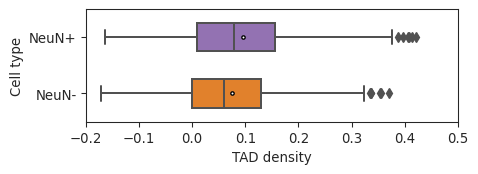

In [83]:
sns.set_style("white")
ax, fig = plt.subplots(figsize = [5,1.53])
box_plot = sns.boxplot(data=df, x="TAD density", y="Cell type",
                       width = 0.5,
                       showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"2.5"},
            order = ["NeuN+", "NeuN-"],
           palette ={"NeuN-": sns.color_palette()[1],"NeuN+": sns.color_palette()[4]},  )
plt.xlim(-0.2, 0.5)

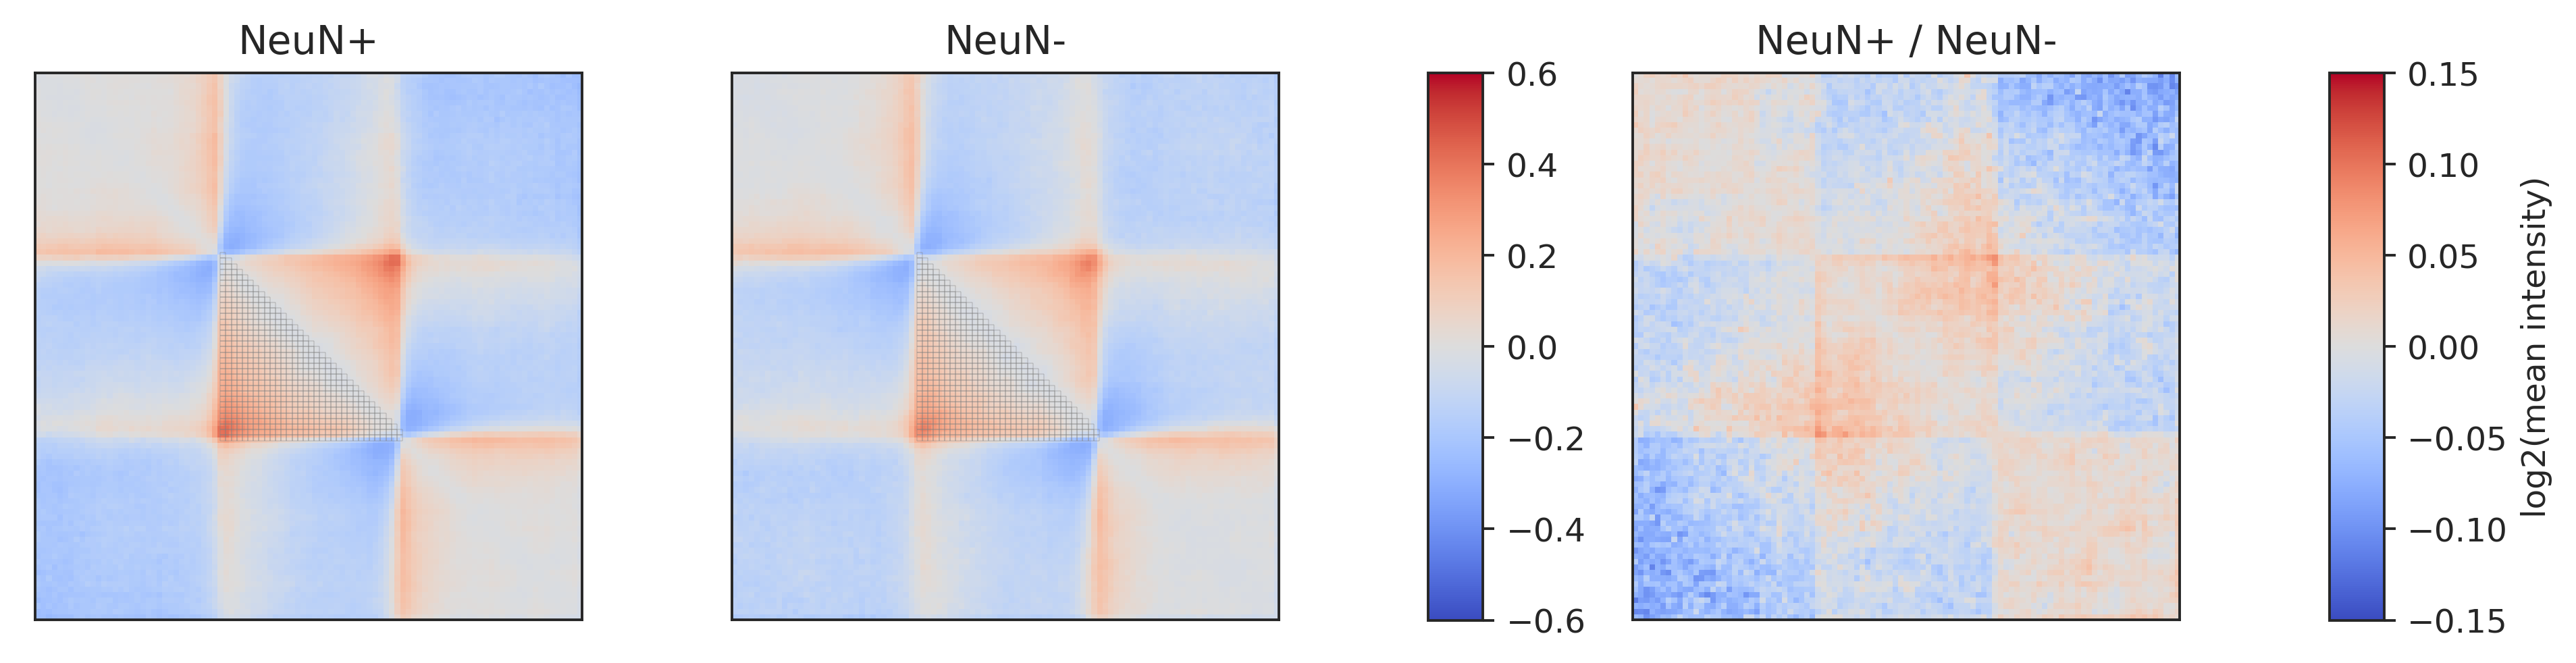

In [20]:
plot_tads_from_list(av_tad)

### 4. Investigate chromatin states

In [56]:
def fix_extention(tad_selected_states2):
    tad_selected_states = tad_selected_states2.copy().reset_index(drop=True)
    for i in range(tad_selected_states.shape[0]):        
        if tad_selected_states.iloc[i].end > tad_selected_states.iloc[i].end1:
            tad_selected_states.loc[i, "end"] = tad_selected_states.iloc[i].end1
        if tad_selected_states.iloc[i].start < tad_selected_states.iloc[i].start1:
            tad_selected_states.loc[i, "start"] = tad_selected_states.iloc[i].start1
    return tad_selected_states
    
def normalize(dict_df, norm):
    df_full = pd.DataFrame(state_lengthes_df_neurons.state.to_list(), columns = ["state"])
    for i in dict_df.keys():
        df = dict_df[i][["state","mean"]].copy()
        df["mean"] = df["mean"]/ norm["state_cov"]
        df = df.rename(columns = {"mean":f"Group {i}"})
        df_full = df.merge(df_full, on ="state")
    df_full_long_plus  = pd.melt(df_full, id_vars='state', value_vars=df_full.columns.tolist()[1:])
    return df_full_long_plus

def make_palette():
    my_pal = {}
    states = [ 'TssA', 'TssFlnk', 'EnhA', 'TssBiv', 'ReprPC', 'Quies']
    cols = ['crimson','salmon',  'orange','indianred',  'grey','lightgrey']
    for state, col in zip(states, cols):
        my_pal[state] =col    
    return my_pal

def save_svg(df_full_long_plus, my_pal, save_path):
    sns.set_theme(style="whitegrid",font_scale=1.52)
    desired_height = 4
    desired_width = 9
    aspect_ratio = desired_width / desired_height
    g = sns.catplot(
        data=df_full_long_plus, kind="bar",
        x="variable", y="log2value", hue="state", height=desired_height, aspect=aspect_ratio,
        palette=my_pal, alpha=0.98 )
    g.despine(left=True)
    g.set_axis_labels("", "log2 (ratio)")
    ticks = [-1, 0, 1, 2,  3]
    # g.set(ylim=(0, 1.5))
    for axes in g.axes.flat:
        _ = axes.set_yticks(ticks)
        _ = axes.set_yticklabels(ticks)    
    for axes in g.axes.flat:
        axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
        axes.tick_params(axis='x', labelsize=9)    
    if save_path:
        plt.savefig(save_path, dpi=450, bbox_inches='tight', format='svg')
    
def interval_annotation_ratio(boundaries_plus_working, ChromHMM_Neuron):      
    colnames = boundaries_plus_working.columns.tolist() + ChromHMM_Neuron.columns.tolist()
    inter = pbt.from_dataframe(boundaries_plus_working)\
                                        .intersect(pbt.from_dataframe(ChromHMM_Neuron), wa=True, wb=True)
    inter = pd.read_table(inter.fn, header = None, names=colnames)
    inter = fix_extention(inter) 
    return inter

def cal_mean(dots_df_HCplus_5_ext_left_states):
    states = ['TssA', 'TssFlnk', 'EnhA', 'TssBiv', 'ReprPC', 'Quies']
    dots_df_HCplus_5_ext_left_states["feature_length"] = dots_df_HCplus_5_ext_left_states["end"] - dots_df_HCplus_5_ext_left_states["start"] 
    dots_df_HCplus_5_ext_left_states['size'] = dots_df_HCplus_5_ext_left_states["end1"]- dots_df_HCplus_5_ext_left_states["start1"]
    state_lengthes_df = pd.DataFrame(states, columns = ["state"])
    for i in tqdm(dots_df_HCplus_5_ext_left_states.border_num.tolist()):   
        df = dots_df_HCplus_5_ext_left_states[dots_df_HCplus_5_ext_left_states.border_num.isin([i])].reset_index(drop=True).copy()
        tad_size = df["size"].tolist()[0]
        state_lengthes = []
        for state in states:
            state_lengthes.append(sum(df[df["state"] == state].feature_length.tolist())/ tad_size)
        state_lengthes_df[i] = state_lengthes   
    ### calculate means
    coeff = 1/ sum(state_lengthes_df.iloc[:,1:].mean(axis=1))
    means = [ i* coeff for i in state_lengthes_df.iloc[:,1:].mean(axis=1).tolist()]
    state_lengthes_df["mean"] = means
    return state_lengthes_df
    
    
def define_states(boundaries_plus, state_lengthes_df_neurons, ChromHMM_Neuron, groups, column_with_border = "border_num1", save_path = None):
    boundaries_plus_working = boundaries_plus.copy()
    boundaries_plus_working = boundaries_plus_working.rename(columns = {"chrom":"chrom1", "start":"start1", "end":"end1",column_with_border:"border_num"})
    
    boundaries_plus_working = interval_annotation_ratio(boundaries_plus_working, ChromHMM_Neuron)
    results = {}
    for comp in groups:
        df = boundaries_plus_working.loc[(boundaries_plus_working.status == comp)].reset_index(drop=True)
        res = cal_mean(df)
        name = comp
        results[name] = {}
        results[name] = res
    
    state_lengthes_df_neurons = state_lengthes_df_neurons.set_index("state").reindex(res.state.tolist()).reset_index()
    df_full_long_plus = normalize(results, state_lengthes_df_neurons)
    df_full_long_plus["log2value"] = np.log2(df_full_long_plus["value"])
    my_pal = make_palette()
    save_svg(df_full_long_plus, my_pal, save_path )
    return df_full_long_plus

def make_overall_coverage(ChromHMM_NonNeuron):
    ChromHMM_NonNeuron['legnth'] = ChromHMM_NonNeuron['end']- ChromHMM_NonNeuron['start']
    state_lengthes_df_glia = ChromHMM_NonNeuron[['state','legnth']].groupby('state').sum() / ChromHMM_NonNeuron["legnth"].sum()
    state_lengthes_df_glia.reset_index(inplace= True)
    state_lengthes_df_glia.columns = ['state', 'state_cov']
    return state_lengthes_df_glia

In [27]:
ChromHMM_Neuron = pd.read_table("../data/ChromHMM_Neuron.bed", sep="\t",header = None)
ChromHMM_NonNeuron = pd.read_table("../data/ChromHMM_NonNeuron.bed", sep="\t",header = None)
ChromHMM_NonNeuron.columns = ["chrom","start","end", "state", "smth","strand","f1","f2","f3"]
ChromHMM_Neuron.columns = ["chrom","start","end", "state", "smth","strand","f1","f2","f3"]

state_lengthes_df_glia = make_overall_coverage(ChromHMM_NonNeuron)
state_lengthes_df_neurons = make_overall_coverage(ChromHMM_Neuron)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9382/9382 [00:36<00:00, 256.70it/s]


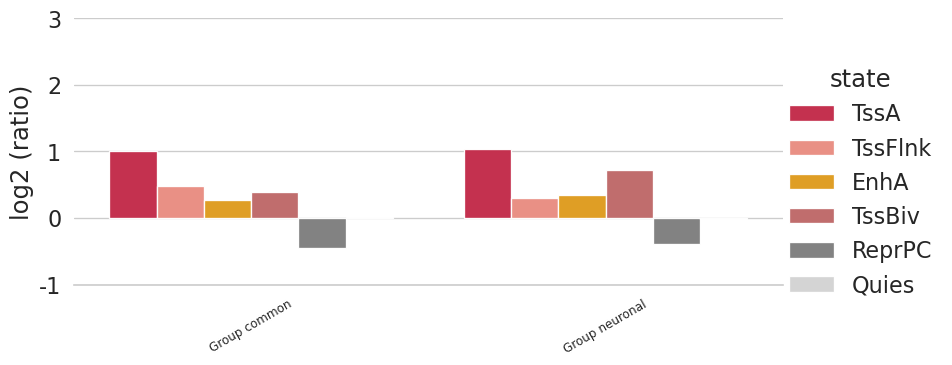

In [54]:
df_full_long_plus_funcr = define_states(boundaries_plus, state_lengthes_df_neurons, ChromHMM_Neuron, ["neuronal","common"], column_with_border = "border_num1")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7711/7711 [00:20<00:00, 382.43it/s]


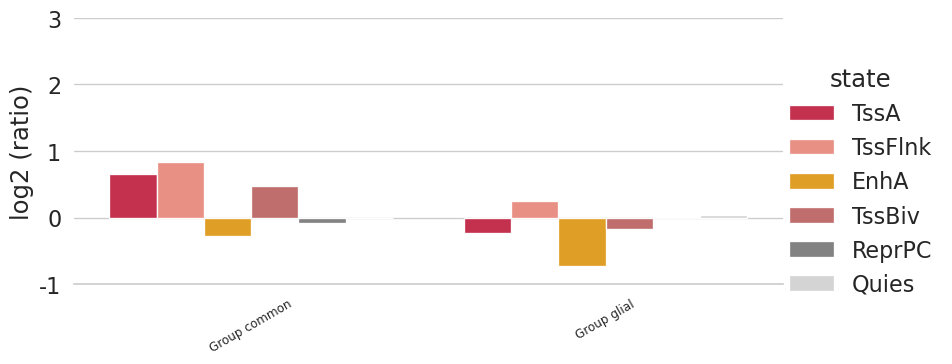

In [58]:
df_full_long_plus_funcr = define_states(boundaries_minus, state_lengthes_df_glia, ChromHMM_NonNeuron, ["glial","common"], column_with_border = "border_num2")

### 5. Intersect with genes

In [61]:
boundaries_minus_sploped = pbt.from_dataframe(boundaries_minus.iloc[:, [0,1,2, 5]]).slop(b=15000, g="../data/chrom.sizes")
boundaries_plus_sploped = pbt.from_dataframe(boundaries_plus.iloc[:, [0,1,2, 5]]).slop(b=15000,g="../data/chrom.sizes")

(5278, 5302)

In [62]:
def make_tss(pc_DE_genes_minus):
    chrom_sizes_path = "../data/chrom.sizes"
    tss = pbt.from_dataframe(pc_DE_genes_minus).flank(g=chrom_sizes_path, s=True, l=1, r=0)
    tss = pd.read_table(tss.fn, header = None, names=pc_DE_genes_minus.columns.tolist())
    return tss
    
def prep_genes(path_gene, make_tss_from_genes = True):
    pc_DE_genes_plus  = pd.read_csv(path_gene, header = None, sep="\t")
    pc_DE_genes_plus.columns = ["chrom2", "start2", "end2", "gene", "log2FC", "strand"]
    if make_tss_from_genes:
        pc_DE_genes_plus = make_tss(pc_DE_genes_plus)
    return pc_DE_genes_plus

In [63]:
def prep_full_annotation():
    genes_strand = pd.read_csv("../data/GENCODE.v41.annotation.bed", sep = "\t", header = None)
    genes_strand.columns = ["chr", "start", "end", "gene.id", "smth", "strand"]
    genes_ensembl = pd.read_csv("../data/rnaseq.rizzardi2019.counts.GENCODE.autosomes_and_chrX.with_meta.tsv", sep = "\t")
    gene_full_annotation = genes_ensembl[["gene.id","gene.name", "gene.type"]].merge(genes_strand, on = "gene.id")
    return gene_full_annotation

In [64]:
def prep_expressed_rizzardi(make_tss_from_genes = True):
    gene_full_annotation = prep_full_annotation()
    genes_annotation = pd.read_csv("../data/GENCODE.v41.annotation.bed", sep="\t", header= None)
    genes_annotation.columns = ["chrom","start","end","gene.id", "f1", "strand"]
    
    rizzardi2019_counts = pd.read_csv("../data/rnaseq.rizzardi2019.counts.GENCODE.autosomes_and_chrX.with_meta.tsv.gz", sep ='\t')
    rizzardi2019_counts = genes_annotation[["chrom","start","end", "strand","gene.id"]].merge(rizzardi2019_counts.drop(columns = ["chrom"]), on = "gene.id")
    columns_samples = [col for col in rizzardi2019_counts.columns if col.startswith('X')]
    rizzardi2019_counts_expressed_genes = rizzardi2019_counts[rizzardi2019_counts[columns_samples].sum(axis=1) > 5].reset_index(drop=True)
    rizzardi2019_counts_expressed_genes = rizzardi2019_counts_expressed_genes[["chrom","start","end","gene.name", "gene.type","strand"]]
    
    if make_tss_from_genes:
        rizzardi2019_counts_expressed_genes = make_tss(rizzardi2019_counts_expressed_genes)
    return rizzardi2019_counts_expressed_genes

In [66]:
def prep_de_genes(make_tss_from_genes = True):
    if make_tss_from_genes:
        rizz_file = rizzardi_expressed
        minus_de_file  =pc_DE_genes_minus
        plus_de_file  = pc_DE_genes_plus
    else:
        rizz_file = rizzardi_expressed_genes
        minus_de_file  =pc_DE_genes_minus_genes
        plus_de_file  =pc_DE_genes_plus_genes
       
    expressed_NOT_de_minus = rizz_file[~rizz_file["gene.name"].isin(pc_DE_genes_minus.gene.to_list())]
    expressed_NOT_de_plus = rizz_file[~rizz_file["gene.name"].isin(pc_DE_genes_plus.gene.to_list())]
    
    expressed_NOT_de_minus.columns = ["chrom2", "start2", "end2", "gene", "type", "strand"]
    expressed_NOT_de_plus.columns = ["chrom2", "start2", "end2", "gene", "type", "strand"]
    expressed_NOT_de_minus = expressed_NOT_de_minus[expressed_NOT_de_minus.type == "protein_coding"]
    expressed_NOT_de_plus = expressed_NOT_de_plus[expressed_NOT_de_plus.type == "protein_coding"]
    return expressed_NOT_de_plus, expressed_NOT_de_minus

In [85]:
pc_DE_genes_plus = prep_genes('../data/rizzardi.pc_DE_genes.upr_in_neu.bed', make_tss_from_genes=True)
pc_DE_genes_minus = prep_genes('../data/rizzardi.pc_DE_genes.upr_in_gli.bed', make_tss_from_genes=True)

In [65]:
rizzardi_expressed = prep_expressed_rizzardi()
rizzardi_expressed_genes = prep_expressed_rizzardi(make_tss_from_genes = False)

In [67]:
expressed_NOT_de_plus_genes, expressed_NOT_de_minus_genes = prep_de_genes(make_tss_from_genes = False)
print(expressed_NOT_de_plus_genes.shape[0], expressed_NOT_de_minus_genes.shape[0])
expressed_NOT_de_plus, expressed_NOT_de_minus = prep_de_genes(make_tss_from_genes = True)
print(expressed_NOT_de_plus.shape[0], expressed_NOT_de_minus.shape[0])

13198 13162
13198 13162


In [73]:
def make_a_b(expressed_not_de, border_file_init):  
    border_file_slopped = pbt.from_dataframe(border_file_init.iloc[:, [0,1,2, 5]]).slop(b=15000, g="../data/chrom.sizes")

    b_noDE = border_file_slopped\
                  .intersect(pbt.from_dataframe(expressed_not_de), wa=True, wb=True)
    b_noDE = pd.read_table(b_noDE.fn, header = None, names=border_file_init.iloc[:, [0,1,2, 5]].columns.tolist()+expressed_not_de.columns.tolist())
    b = b_noDE.gene.nunique()
    a = expressed_not_de.gene.nunique() - b
    return_list_up_border = b_noDE.gene.unique().tolist()
    return a, b

In [74]:
def make_analysis(expressed_NOT_de_plus,pc_DE_genes_plus,  border_plus):
    a, b, smth = make_a_b(expressed_NOT_de_plus, border_plus)
    c, d, list_up_border = make_a_b(pc_DE_genes_plus, border_plus)
    table = np.array([[   a,  b],
                      [  c, d]  ])
    oddsratio, pvalue = stats.fisher_exact(table)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)
    return list_up_border, table

In [79]:
a, b = make_a_b(expressed_NOT_de_plus,boundaries_plus)
c, d = make_a_b(pc_DE_genes_plus, boundaries_plus)
table = np.array([[   a,  b],
                  [  c, d]  ])
oddsratio, pvalue = fisher_exact(table)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

OddsR:  1.0847889701932285 p-Value: 0.08782128700718764


In [81]:
a, b = make_a_b(expressed_NOT_de_minus, boundaries_minus)
c, d = make_a_b(pc_DE_genes_minus, boundaries_minus)
table = np.array([[   a,  b],
                  [  c, d]  ])
oddsratio, pvalue = fisher_exact(table)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

OddsR:  0.8240541054241616 p-Value: 0.0003195781577038139


### 6. TADs in LADs

In [100]:
def identify_group(boundaries_hc_minus):
    boundaries_hc_minus = boundaries_hc_minus.iloc[:, [0,1,2]]
    boundaries_hc_minus.columns = ['chrom', 'start', 'end']
    boundaries_hc_minus["end"] = boundaries_hc_minus["end"]-15000
    tad_hc_minus_ch, tad_hc_minus_start, tad_hc_minus_end = [], [], []

    for i in range(boundaries_hc_minus.shape[0]-1):
        if boundaries_hc_minus.chrom[i+1] == boundaries_hc_minus.chrom[i]:
            tad_hc_minus_ch.append(boundaries_hc_minus.chrom[i])
            tad_hc_minus_start.append(boundaries_hc_minus.start[i])
            tad_hc_minus_end.append(boundaries_hc_minus.end[i+1])
    tad_hc_minus_df = pd.DataFrame(zip(tad_hc_minus_ch,tad_hc_minus_start,tad_hc_minus_end),columns = ['chrom', 'start', 'end'])
    return tad_hc_minus_df

def make_group_any_extreme(df, param):
    tad_hc_minus = df[param].tolist()
    groups = [0.99]
    tad_hc_minus_groups = []
    for item in tad_hc_minus:
        if item < groups[0]:
            tad_hc_minus_groups.append(0)        
        else:
            tad_hc_minus_groups.append(1)
    assert len(tad_hc_minus_groups) == df.shape[0]
    return tad_hc_minus_groups

def make_group_any_extremeTotal(df, param):
    tad_hc_minus = df[param].tolist()
    groups = [0.99]
    tad_hc_minus_groups = []
    for item in tad_hc_minus:
        if item < groups[0]:
            tad_hc_minus_groups.append(0)        
        else:
            tad_hc_minus_groups.append(1)
    assert len(tad_hc_minus_groups) == df.shape[0]
    return tad_hc_minus_groups


def make_group_any_extremeTotal_0(df, param):
    tad_hc_minus = df[param].tolist()
    groups = [0.01]
    tad_hc_minus_groups = []
    for item in tad_hc_minus:
        if item < groups[0]:
            tad_hc_minus_groups.append(0)        
        else:
            tad_hc_minus_groups.append(1)
    assert len(tad_hc_minus_groups) == df.shape[0]
    return tad_hc_minus_groups
    
def get_lad_cov(boundaries_plus_common_tad, all_h3k27me3_peaks_plus):
    h3k27me3_coverage = []
    for i in tqdm(range(boundaries_plus_common_tad.shape[0])):
        df = pd.DataFrame(boundaries_plus_common_tad.iloc[i]).T
        tad_peak = pbt.from_dataframe(df)\
                                            .intersect(pbt.from_dataframe(all_h3k27me3_peaks_plus))
        tad_peak = pd.read_table(tad_peak.fn, header = None, names=df.columns.tolist())
        tad_peak["length"] = tad_peak["end"] - tad_peak["start"]
       
        h3k27me3_coverage.append(sum(tad_peak.length.tolist()))
        
    boundaries_plus_common_tad["h3k27me3_coverage"] = h3k27me3_coverage
    boundaries_plus_common_tad["size"] = boundaries_plus_common_tad["end"] - boundaries_plus_common_tad["start"]
    boundaries_plus_common_tad["h3k27me3_coverage_per"] = boundaries_plus_common_tad["h3k27me3_coverage"] / boundaries_plus_common_tad["size"]
    return boundaries_plus_common_tad

def make_group_any(df, param):
    tad_hc_minus = df[param].tolist()
    groups = np.quantile(tad_hc_minus, [0,0.33,0.67,1])
    tad_hc_minus_groups = []
    for item in tad_hc_minus:
        if item <=groups[1]:
            tad_hc_minus_groups.append(0)
        if item <=groups[2] and item > groups[1]:
            tad_hc_minus_groups.append(1)      
        if item > groups[2]:
            tad_hc_minus_groups.append(2)
    assert len(tad_hc_minus_groups) == df.shape[0]
    return tad_hc_minus_groups

def make_cat_group(boundaries_plus_prep_LADS):
    lad_cov_group = []
    for i in range(boundaries_plus_prep_LADS.shape[0]):
        cnt=0
        if boundaries_plus_prep_LADS.iloc[i].LAD_group_extremeTotal ==1:
            lad_cov_group.append("in LAD")
            cnt+=1
        elif boundaries_plus_prep_LADS.iloc[i].LAD_group_extremeTotal_0 ==0:
            lad_cov_group.append("out of LAD")
            cnt+=1
        else:
            lad_cov_group.append("intermediate")
            cnt+=1
        if cnt>1 or cnt==0:
            print(i)
    return lad_cov_group

In [97]:
GW20_Cortex_LaminB_peaks_clean = pd.read_csv("../data/GW20_Cortex_LaminB_peaks_clean.bed",header = None,sep="\t")
GW20_Cortex_LaminB_peaks_clean["size"] = GW20_Cortex_LaminB_peaks_clean[2] - GW20_Cortex_LaminB_peaks_clean[1]

In [94]:
boundaries_plus_prep = identify_group(boundaries_plus)
boundaries_minus_prep= identify_group(boundaries_minus)

In [101]:
boundaries_minus_prep_LADS = get_lad_cov(boundaries_minus_prep, GW20_Cortex_LaminB_peaks_clean)
boundaries_minus_prep_LADS["LAD_group"] = make_group_any(boundaries_minus_prep_LADS, "h3k27me3_coverage_per")

In [103]:
boundaries_plus_prep_LADS = get_lad_cov(boundaries_plus_prep, GW20_Cortex_LaminB_peaks_clean)
boundaries_plus_prep_LADS["LAD_group"] = make_group_any(boundaries_plus_prep_LADS, "h3k27me3_coverage_per")

In [104]:
boundaries_plus_prep_LADS["LAD_group_extreme"] = make_group_any_extreme(boundaries_plus_prep_LADS, "h3k27me3_coverage_per")
boundaries_minus_prep_LADS["LAD_group_extreme"] = make_group_any_extreme(boundaries_minus_prep_LADS, "h3k27me3_coverage_per")

In [105]:
boundaries_plus_prep_LADS["LAD_group_extremeTotal_0"] = make_group_any_extremeTotal_0(boundaries_plus_prep_LADS, "h3k27me3_coverage_per")
boundaries_minus_prep_LADS["LAD_group_extremeTotal_0"] = make_group_any_extremeTotal_0(boundaries_minus_prep_LADS, "h3k27me3_coverage_per")

boundaries_plus_prep_LADS["LAD_group_extremeTotal"] = make_group_any_extremeTotal(boundaries_plus_prep_LADS, "h3k27me3_coverage_per")
boundaries_minus_prep_LADS["LAD_group_extremeTotal"] = make_group_any_extremeTotal(boundaries_minus_prep_LADS, "h3k27me3_coverage_per")

In [108]:
lad_cov_group = make_cat_group(boundaries_plus_prep_LADS)
boundaries_plus_prep_LADS["LAD_cov_group"] = lad_cov_group

lad_cov_group = make_cat_group(boundaries_minus_prep_LADS)
boundaries_minus_prep_LADS["LAD_cov_group"] = lad_cov_group

In [109]:
boundaries_minus_prep_LADS["size3group"] = make_group_any(boundaries_minus_prep_LADS, "size")
boundaries_plus_prep_LADS["size3group"] = make_group_any(boundaries_plus_prep_LADS, "size")


In [110]:
large_tads_in_lad_plus = boundaries_plus_prep_LADS.loc[(boundaries_plus_prep_LADS.size3group == 2) & (boundaries_plus_prep_LADS.LAD_group_extremeTotal == 1)]
large_tads_in_lad_minus = boundaries_minus_prep_LADS.loc[(boundaries_minus_prep_LADS.size3group == 2) & (boundaries_minus_prep_LADS.LAD_group_extremeTotal == 1)]
tads_in_lad_plus = boundaries_plus_prep_LADS.loc[(boundaries_plus_prep_LADS.LAD_group_extremeTotal == 1) ]
tads_in_lad_minus = boundaries_minus_prep_LADS.loc[(boundaries_minus_prep_LADS.LAD_group_extremeTotal == 1) ]

tads_NOT_in_lad_plus = boundaries_plus_prep_LADS.loc[(boundaries_plus_prep_LADS.LAD_group_extremeTotal != 1) ]
tads_NOT_in_lad_minus = boundaries_minus_prep_LADS.loc[(boundaries_minus_prep_LADS.LAD_group_extremeTotal != 1) ]

In [130]:
def prepare_border_file(file, col):      
    file1 = file[["chrom", "start","end",col]   ] 
    return file1

def build_average_tad_self_border_SIZE(file_plus, file_minus, col, clrs_15, exps_15):
    file_usage_plus = prepare_border_file(file_plus, col)
    file_usage_minus = prepare_border_file(file_minus, col)
    names = ["clr_HC_plus","clr_HC_minus"]
    groups = [0,1, 2]
    stacks =[]
    for group in groups:
        file_usage_group_plus = file_usage_plus[file_usage_plus[col]==group]  
        file_usage_group_minus = file_usage_minus[file_usage_minus[col]==group]
        assert file_usage_group_plus.shape[0] >0
        assert file_usage_group_minus.shape[0] >0
        files_usage = [file_usage_group_plus, file_usage_group_minus]
        for i, file in enumerate(files_usage):   
            cc = coolpup.CoordCreator(file, resolution=15000, flank=300_000,
                                      features_format='bed', local=True, 
                                      rescale_flank=1)
            pu = coolpup.PileUpper( clrs_15[i], cc, expected=exps_15[i],
                                   view_df=hg38_arms, 
                                   ignore_diags=1, 
                                   rescale_size=99, rescale=True)
            pup = pu.pileupsWithControl(nproc=10)
            stacks.append((pup.data)[0])
    return stacks

In [161]:
### Prepare mcool files
def load_mcools(path_to_maps,name_mcool_minus, name_mcool_plus, expected_minus_path = None, expected_plus_path = None, resolution = 15_000, ):
    clr_HC_minus = cooler.Cooler(f'{path_to_maps}/{name_mcool_minus}::/resolutions/{resolution}')
    clr_HC_plus = cooler.Cooler(f'{path_to_maps}/{name_mcool_plus}::/resolutions/{resolution}')
    hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
    hg38_cens = bioframe.fetch_centromeres('hg38')
    hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
    if expected_minus_path and  expected_plus_path:
        expected_plus = pd.read_csv(expected_plus_path)
        expected_minus = pd.read_csv(expected_minus_path)
    else:
        expected_minus = expected_cis(
        clr_HC_minus,
        ignore_diags=1,
        view_df=hg38_arms,
        chunksize=1000000,
        nproc=15)
    
        expected_plus = expected_cis(
        clr_HC_plus,
        ignore_diags=1,
        view_df=hg38_arms,
        chunksize=1000000,nproc=15
        )
    
    clrs_15 = [clr_HC_plus,clr_HC_minus]
    exps_15 = [expected_plus, expected_minus]
    return clrs_15, exps_15

def plot_TAD_LAD(files, group, vmin = -0.8, vmax = 0.8):   
    print(f"Group {group}")    
    plt.rcParams['axes.facecolor'] = 'white'
    sns.set_style("ticks")
    fig, axs = plt.subplots(1, 5,figsize=(20,9.0), 
                            dpi=100,
                                gridspec_kw={'width_ratios': [1, 1, 0.1, 1, 0.1]})
    for i in range(3): 
        if i!=2:
            vmin = vmin
            vmax = vmax   
            map_inv = files[i]
            im_raw = axs[i].imshow(np.log2(map_inv), vmin=vmin ,vmax=vmax,
                                          cmap='coolwarm')
        else:
            vmin = vmin/2
            vmax = vmax/2            
            map_inv = files[0] / files[1]
            im = axs[i+1].imshow(np.log2(map_inv), vmin=vmin ,vmax=vmax,
                                          cmap='coolwarm')        
    axs[0].set_title('NeuN+')
    axs[1].set_title('NeuN-') 
    plt.colorbar(im, cax=axs[4])
    plt.colorbar(im_raw, cax=axs[2])
    axs[2].set_box_aspect(10)    
    axs[3].set_title('NeuN+ /NeuN-')    
    axs[4].set_box_aspect(10) 
    axs[4].set_ylabel("log2(mean intensity)")
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.44, hspace=0.2)
    plt.show()

In [162]:
path_to_maps = "../data/"
name_mcool_minus = "NeuNminus.sampled.1000.mcool"
name_mcool_plus = "NeuNplus.sampled.1000.mcool"
resolution = 15_000
clrs_ignor1, exps_ignore1 = load_mcools(path_to_maps, name_mcool_minus, name_mcool_plus)
stask_lads_extreme_SIZES = build_average_tad_self_border_SIZE(tads_in_lad_plus, tads_in_lad_minus, "size3group", clrs_ignor1, exps_ignore1,)


Group 0


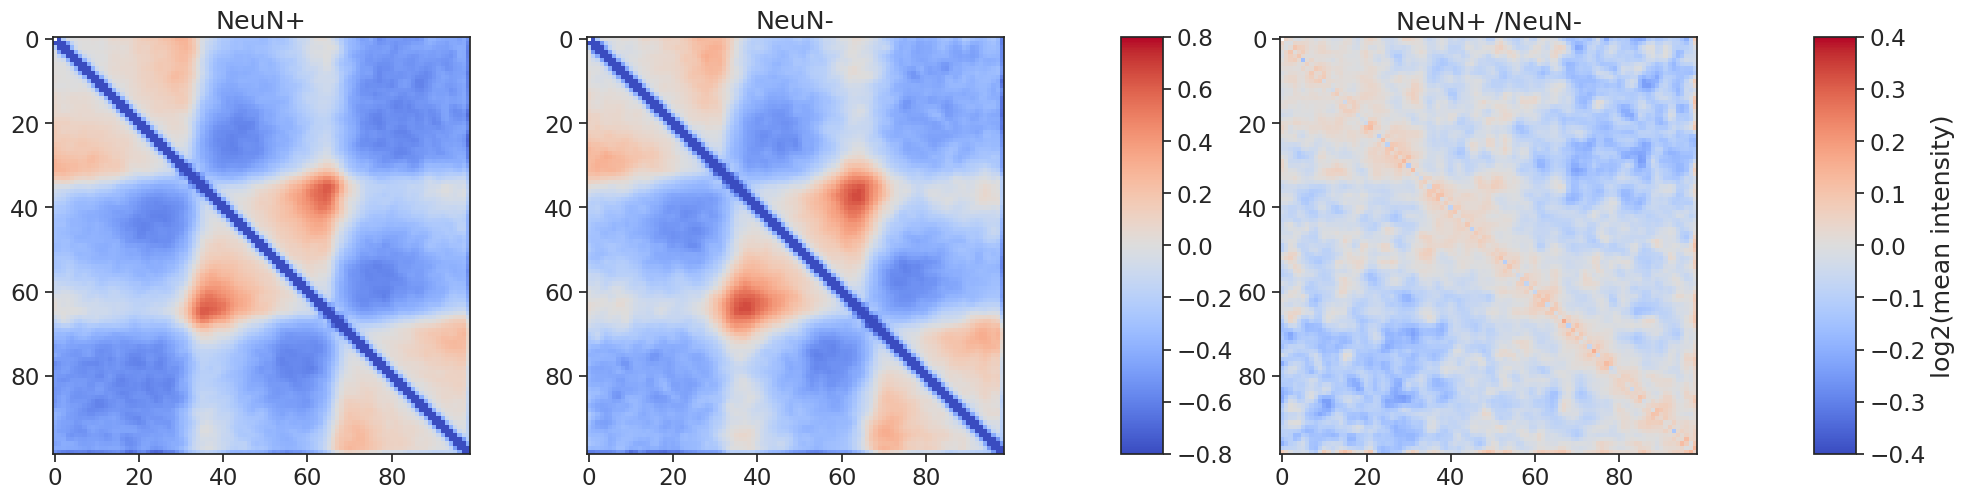

Group 1


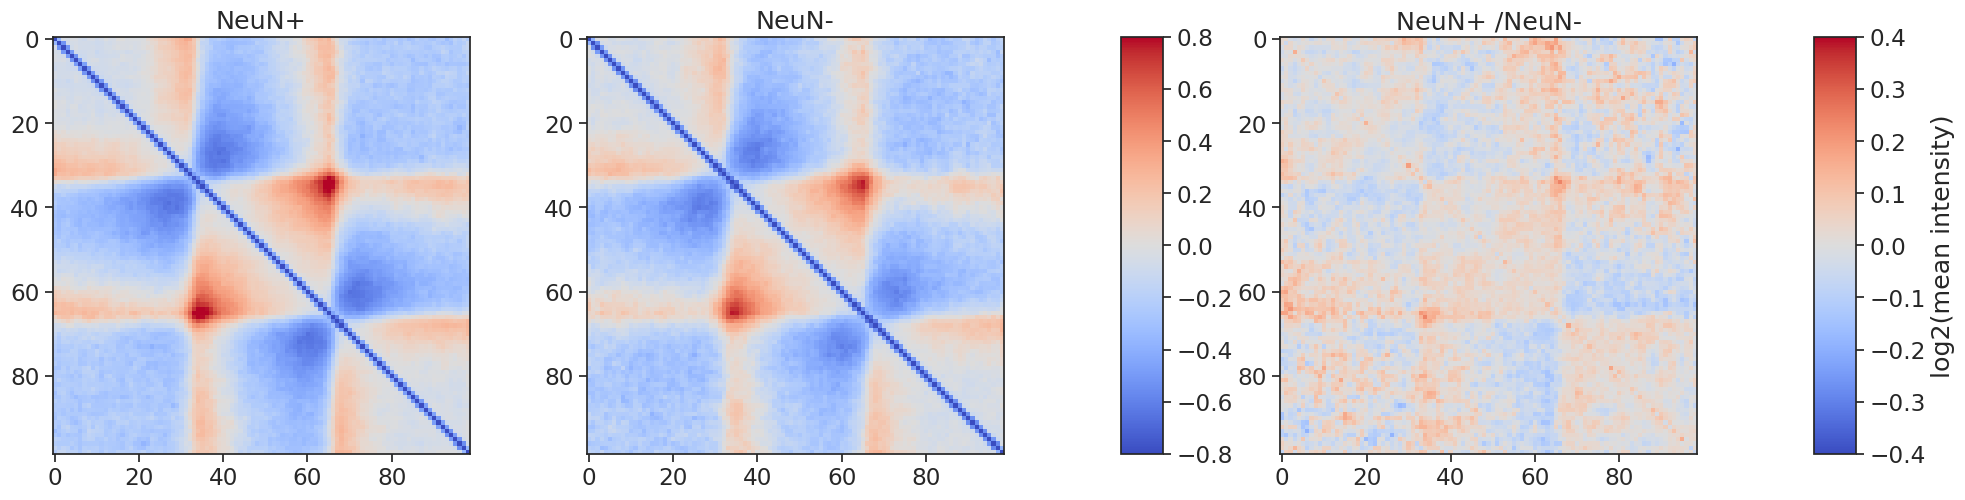

Group 2


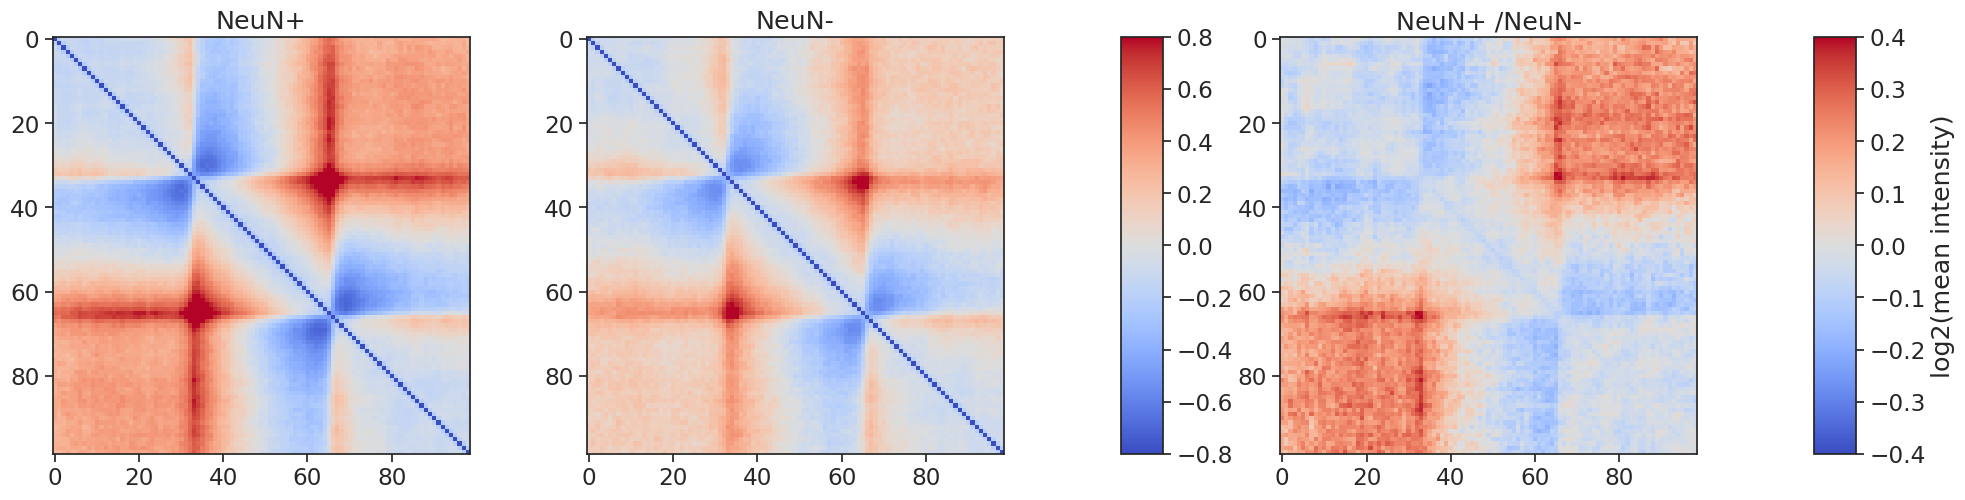

In [163]:
cnt=0
for i in range(3):
    files = stask_lads_extreme_SIZES[cnt :cnt+2]
    plot_TAD_LAD(files, i)
    cnt+=2